####  From 2023-2024, DAS data were recorded on three seafloor fiber optic cables in Cook Inlet in Alaska. The active seismic character of this subduction zone region makes this a rich dataset, with thousands of recorded earthquakes.

<img src="https://raw.githubusercontent.com/uwfiberlab/sz4d_das_workshop/9123a2ebb879b331616a3aa9d2c074535d5a4ec4/notebooks/zoe/CIDAS_tectonic.png" width="300"/>

#### This recorded DAS dataset is publicly available as event-specific earthquake data files. The dataset and descriptors can be found here:

https://fiberlab.uw.edu/projects/alaska-cook-inlet/

#### To get acquainted with DAS data, we are going to look at just one earthquake-specific data file. I have chosen an M5.0 earthquake that occurs relatively close to the cable so that we can very clearly see it in the data. The catalog details of this earthquake can be found here:

https://earthquake.usgs.gov/earthquakes/eventpage/ak0239lyp68s/executive

#### DAS data are available for multiple cables for different earthquakes (KKFLN, KKFLS, TERRA). KKFLN is the cable that trends north, TERRA is the cable that runs east-west, and KKFLS is the cable that trends south. We can download the data for one of these cables for this event using wget with the URL to the file. 

In [1]:
!wget -O TERRA.h5 https://dasway.ess.washington.edu/gci/events/2023-07-28/11726446/TERRA.h5

--2025-12-05 17:24:14--  https://dasway.ess.washington.edu/gci/events/2023-07-28/11726446/TERRA.h5
Resolving dasway.ess.washington.edu (dasway.ess.washington.edu)... 128.208.23.57
Connecting to dasway.ess.washington.edu (dasway.ess.washington.edu)|128.208.23.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102431928 (98M) [application/octet-stream]
Saving to: ‘TERRA.h5’

TERRA.h5            100%[===================>]  97.69M  49.1MB/s    in 2.0s    

2025-12-05 17:24:17 (49.1 MB/s) - ‘TERRA.h5’ saved [102431928/102431928]



#### Now we have some data! It's in h5 file format, which is typical for DAS data. Let's read this in and see what's in the file.

In [2]:
import h5py  # DAS usualy comes in HDF5 format
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

#### Let's open our h5 file and see what it contains by simply looping through the components. We see that the main h5 group is called "Acquisition", and within that the raw data and metadata that we need.

In [3]:
h5file = 'TERRA.h5'
with h5py.File(h5file, 'r') as fp:
    for j in fp:
        print(j)

Acquisition


In [4]:
with h5py.File(h5file, 'r') as fp:
    for j in fp['Acquisition']:
        print(j)

Raw[0]


In [5]:
with h5py.File(h5file, 'r') as fp:
    for j in fp['Acquisition']['Raw[0]']:
        print(j)

RawData
RawDataSampleCount
RawDataTime


### Let's figure out the shape of our raw data.

In [6]:
with h5py.File(h5file, 'r') as fp:
    RawData = fp['Acquisition']['Raw[0]']['RawData'][:]
    print('Raw data shape = '+str(np.shape(RawData)))
    RawDataSampleCount = fp['Acquisition']['Raw[0]']['RawDataSampleCount'][:]
    print('Raw data sample count = '+str(np.shape(RawDataSampleCount)))
    RawDataTime = fp['Acquisition']['Raw[0]']['RawDataTime'][:]
    print('Raw data time count = '+str(np.shape(RawDataTime)))

Raw data shape = (3000, 8531)
Raw data sample count = (3000,)
Raw data time count = (3000,)


#### We see that our raw data has a shape of (3000,8531). We see that these are 3000 samples in time, with 8531 channels in space.

#### What else does this h5 file contain? We can see that the attributes of the Acquisition group contain lots of metadata.

In [7]:
data = h5py.File(h5file)
attrs=dict(data['Acquisition'].attrs)
data.close()
attrs

{'AcquisitionId': b'/',
 'BandDataMaxUserValue': 0.0,
 'BandDataMinUserValue': 0.0,
 'Build': b'5.18.18_P',
 'CommitHash': b'4d27a7aa',
 'DasInstrumentBox': b'ONYX',
 'DetectionAccuracy': b'Not Applicable',
 'FFID': 0,
 'FiberID': 1,
 'GaugeLength': 17.547619476207263,
 'GaugeLengthUnit': b'm',
 'Hostname': b'ONYX-0203',
 'MaximumFrequency': 12.5,
 'MeasurementStartTime': '2023-07-28T19:11:34.280000+00:00',
 'MinimumFrequency': 0.0,
 'NumberOfLoci': 8531,
 'OpticalPath': b'OpticalPath',
 'PulseRate': 25.0,
 'PulseRateUnit': b'Hz',
 'PulseWidth': 20.0,
 'PulseWidthUnit': b'ns',
 'SoftwareVersion': b'3176',
 'SpatialSamplingInterval': 9.571428805203961,
 'SpatialSamplingIntervalUnit': b'm',
 'StartLocusIndex': 0,
 'SystemType': b'Xavier',
 'TriggeredMeasurement': 0,
 'schemaVersion': b'2.0',
 'uuid': b'a1f4f3aa-3c24-4100-b113-cbc986573304'}

#### This shows us that the channel spacing is 9.57 m, and the sampling rate of the data is 25 Hz.

#### Now that we have seen what's in our h5 file, let's save it in useful variables for plotting.

In [8]:
data = h5py.File(h5file)
attrs=dict(data['Acquisition'].attrs)
das = np.array(data['Acquisition/Raw[0]/RawData'])
time = np.array(data['Acquisition/Raw[0]/RawDataTime'])
data.close()

#### Let's try plotting this up to see what the raw data looks like. Remember we have data in time (which here I plot on the y-axis) and space (which here I plot on the x-axis). Even in the raw data, we can see a clear earthquake arrival across the cable at ~800 s.

#### This is referred to as a "waterfall" plot.

Text(0.5, 0, 'Space (channel number)')

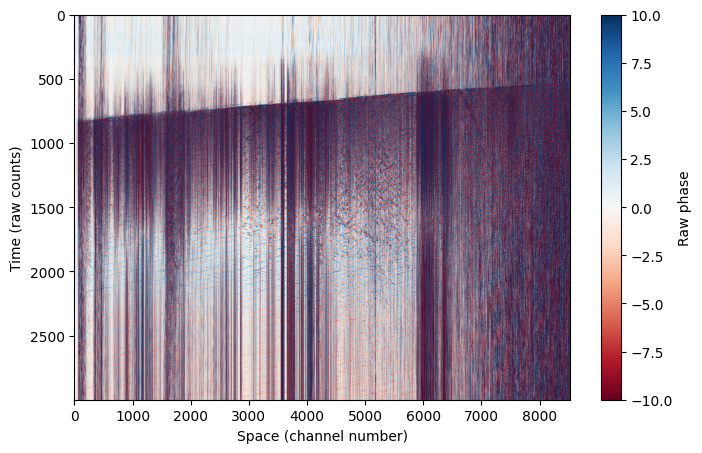

In [9]:
plt.figure(figsize=(8,5))
plt.imshow(das, aspect='auto', cmap='RdBu',vmin=-10,vmax=10)
plt.colorbar(label='Raw phase')
plt.ylabel('Time (raw counts)')
plt.xlabel('Space (channel number)')

#### Because we know the sampling rate and channel spacing of our data, we can change these axes to something more meaningful.

In [10]:
dt = 1/attrs['MaximumFrequency']/2
dx = attrs['SpatialSamplingInterval']
nt,nx = das.shape

x = np.linspace(0,nx*dx,nx) # This is in meters
x_km = x / 1000
t = np.linspace(0,nt*dt,nt)

Text(0.5, 0, 'Distance along cable (km)')

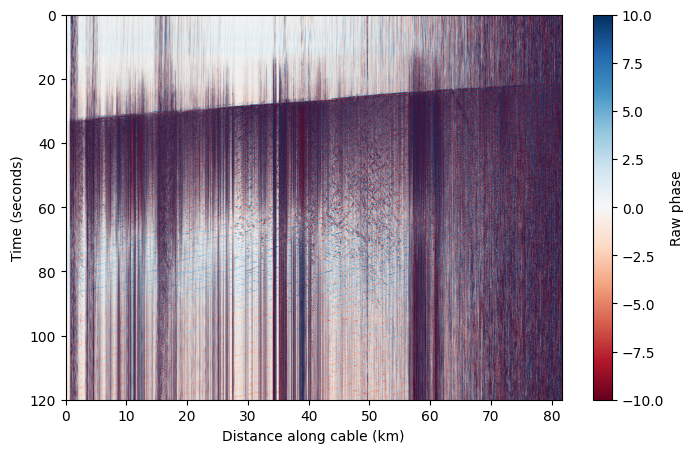

In [11]:
plt.figure(figsize=(8,5))
plt.imshow(das, aspect='auto', cmap='RdBu',vmin=-10,vmax=10,extent=[x_km[0],x_km[-1],t[-1],t[0]])
plt.colorbar(label='Raw phase')
plt.ylabel('Time (seconds)')
plt.xlabel('Distance along cable (km)')

#### Because we know that this data contains an earthquake, we can filter the data to relevant regional/local earthquake frequencies to see the arrivals more clearly and filter out other background noise. 

In [12]:
# Bandpass filter between 2 and 10 Hz
b,a = butter(2,[2,10],'bandpass',fs=1/dt)
das_filtered = filtfilt(b,a,das,axis=0)

Text(0.5, 0, 'Distance along cable (km)')

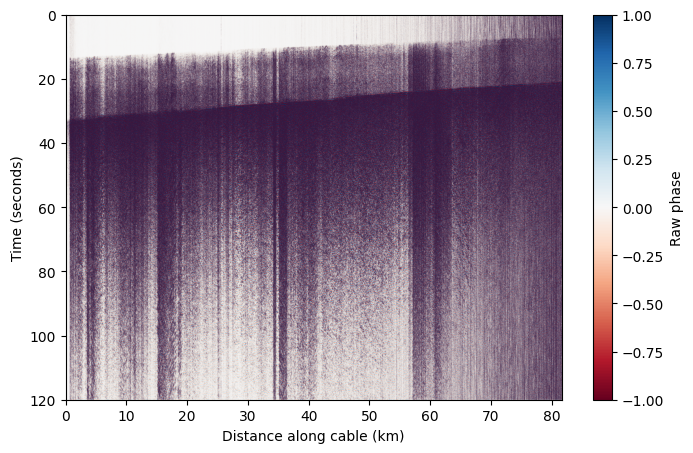

In [13]:
plt.figure(figsize=(8,5))
plt.imshow(das_filtered, aspect='auto', cmap='RdBu',vmin=-1,vmax=1,extent=[x_km[0],x_km[-1],t[-1],t[0]])
plt.colorbar(label='Raw phase')
plt.ylabel('Time (seconds)')
plt.xlabel('Distance along cable (km)')

#### When we limit the colorscale, we can see there are multiple phase arrivals. Let's zoom in and see what the approximate apparent velocity of arriving phases is across the cable. We see that the apparent velocity varies along the cable because it is curved, and the apparent velocity is typically greater than expected for seismic phases.

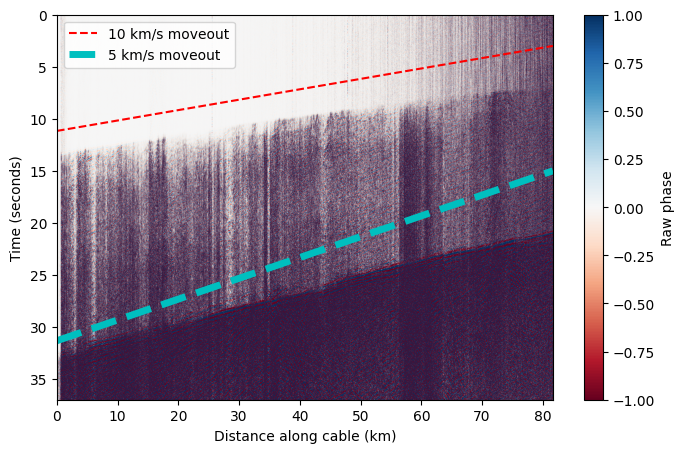

In [14]:
plt.figure(figsize=(8,5))
plt.imshow(das_filtered, aspect='auto', cmap='RdBu',vmin=-1,vmax=1,extent=[x_km[0],x_km[-1],t[-1],t[0]])
plt.ylim(37,0)
plt.colorbar(label='Raw phase')
plt.ylabel('Time (seconds)')
plt.xlabel('Distance along cable (km)')


# Plot a velocity moveout
vel = 10 # km/s
test_x = np.linspace(x_km[0],x_km[-1])
test_t = test_x * (1/vel) + 3
plt.plot(test_x,test_t[::-1],'r--',label='10 km/s moveout')

vel = 5 # km/s
test_x = np.linspace(x_km[0],x_km[-1])
test_t = test_x * (1/vel) + 15
plt.plot(test_x,test_t[::-1],'c--',linewidth=5,label='5 km/s moveout')


plt.legend()

#### We can also look at a single channel, and see that it looks a lot like a seismogram of an earthquake!

Text(0, 0.5, 'Raw phase')

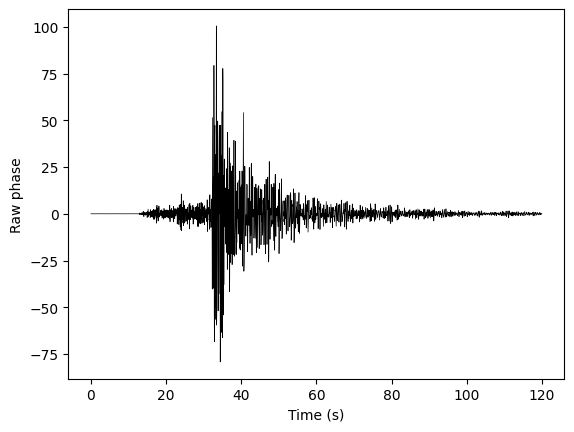

In [15]:
# Here we're just pulling out channel 500
fig,ax = plt.subplots(1)
ax.plot(t,das_filtered[:,500],'k-',linewidth=0.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Raw phase')

### Thus far, we've been looking at raw phase. Let's convert this phase to strain.

#### DAS uses optical interferometry to measure the phase change induced by a change in optical path length, $\Delta \Phi$. This can be related to strain as follows:

## $\epsilon_{xx}(t, x_j) = \frac{\lambda}{4\pi \eta L_G \zeta}\Delta \Phi$

#### Where $\lambda$ is the wavelength of the laser in the DAS interrogator, $\eta$ is the refractive index of the glass within the fiber optic cable, $L_G$ is the gauge length used in acquisition, and $\zeta$ is the photo-elastic coefficient. See [Lindsey et al. 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019JB018145) for more information.



Let's first retrieve the gauge length used in acquisition, which we can take from the attributes portion of the h5 file.

In [16]:
gl = attrs['GaugeLength']
print('Gauge length = ' + str(gl) + ' m')

Gauge length = 17.547619476207263 m


The other variables are constants that we define here.

In [17]:
wavelength = 1550 * 1e-9 # wavelength, 1550 nm
refractive_index = 1.4682
photoelastic_coefficient = 0.78

#### We convert the DAS data to strain using this equation and these coefficients.

In [18]:
correction_factor = wavelength / (photoelastic_coefficient * 4 * np.pi * refractive_index * gl) # correction factor for strain rate

In [19]:
corrected_das = das_filtered * correction_factor

Text(0.5, 0, 'Distance along cable (km)')

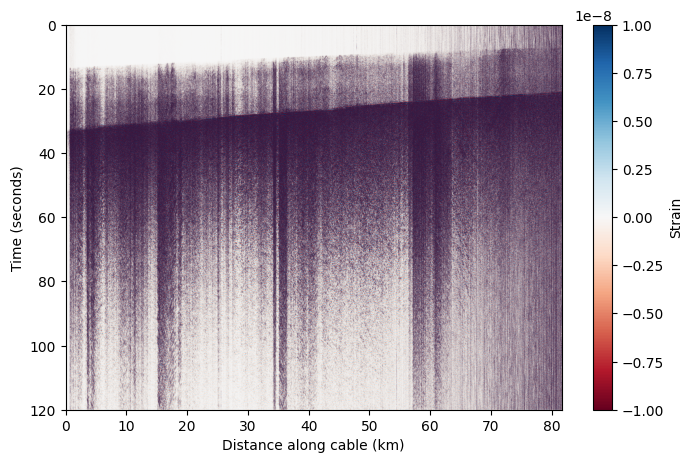

In [20]:
plt.figure(figsize=(8,5))
plt.imshow(corrected_das, aspect='auto', cmap='RdBu',vmin=-0.1e-7,vmax=0.1e-7,extent=[x_km[0],x_km[-1],t[-1],t[0]])
plt.colorbar(label='Strain')
plt.ylabel('Time (seconds)')
plt.xlabel('Distance along cable (km)')

## Ta-da! We now we have a DAS earthquake record we can work with! 
#### Next steps include incorporating the cable geometry to understand where each DAS channel is in lat/lon, etc.

#### Feel free to play around with plotting other earthquakes, on other cables, that you find in the database. Below are some cells that take the relevant parts of this notebook to nicely plot a different h5 file.
#### Try using the "daily reports" of recorded earthquakes on the same index page, which show waterfall plots for both recording cables, to find a nice earthquake to plot.
## https://dasway.ess.washington.edu/gci/index.html

In [21]:
# URL to earthquake data here
!wget -O KKFLS.h5 https://dasway.ess.washington.edu/gci/events/2023-08-03/11728940/KKFLS.h5

--2025-12-01 23:45:56--  https://dasway.ess.washington.edu/gci/events/2023-08-03/11728940/KKFLS.h5
Resolving dasway.ess.washington.edu (dasway.ess.washington.edu)... 128.208.23.57
connected. to dasway.ess.washington.edu (dasway.ess.washington.edu)|128.208.23.57|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 102431928 (98M) [application/octet-stream]
Saving to: ‘KKFLS.h5’

KKFLS.h5            100%[===================>]  97.69M  49.3MB/s    in 2.0s    

2025-12-01 23:45:58 (49.3 MB/s) - ‘KKFLS.h5’ saved [102431928/102431928]



In [22]:
h5file = 'KKFLS.h5'

In [23]:
# Read in data
data = h5py.File(h5file)
attrs=dict(data['Acquisition'].attrs)
das = np.array(data['Acquisition/Raw[0]/RawData'])
time = np.array(data['Acquisition/Raw[0]/RawDataTime'])
data.close()

# Retrieve relevant metadata
dt = 1/attrs['MaximumFrequency']/2
dx = attrs['SpatialSamplingInterval']
nt,nx = das.shape
x = np.linspace(0,nx*dx,nx) # This is in meters
x_km = x / 1000
t = np.linspace(0,nt*dt,nt)
gl = attrs['GaugeLength']

# Bandpass filter between 2 and 10 Hz
b,a = butter(2,[2,10],'bandpass',fs=1/dt)
das_filtered = filtfilt(b,a,das,axis=0)

# Convert to strain
correction_factor = wavelength / (photoelastic_coefficient * 4 * np.pi * refractive_index * gl) 
corrected_das = das_filtered * correction_factor

Text(0.5, 0, 'Distance along cable (km)')

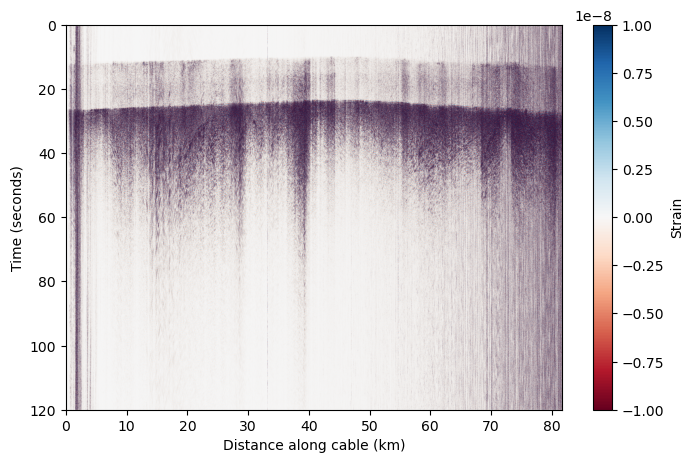

In [24]:
# Plot!
plt.figure(figsize=(8,5))
plt.imshow(corrected_das, aspect='auto', cmap='RdBu',vmin=-0.1e-7,vmax=0.1e-7,extent=[x_km[0],x_km[-1],t[-1],t[0]])
plt.colorbar(label='Strain')
plt.ylabel('Time (seconds)')
plt.xlabel('Distance along cable (km)')